In [32]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.random as rand

from makeCorner import *

az.rcParams["plot.max_subplots"] = 80

Amount of divergences >> 200 for:
- logit width
- logit middle z (but is slightly better than middle z)
- no logit

Divergences: 89 for
- lower upper range of prior, 80 instead of 90 for middle_m

61 for:
- Different seed

77 for:
- Use of dense_mass parameter

32 for:
- prior change from 20 to 75

In [2]:
# cdf_file = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Redshift_in_Mass_sigmoid/cdf_files_sigmoid//CBC_O3_smaller_priors_on_middle_m_30_75.cdf"
# "./RUNS/CBC_O3_Reverse_Sector.cdf"
cdf_file = "../data/RUNS/my_reverse_sector_logit_for_middle_z_until_75_from_20_seed_110.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

/home/max.lalleman/.conda/envs/autoregressive-pop-modeling/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (43), generating only 40 plots
  warnings.warn(


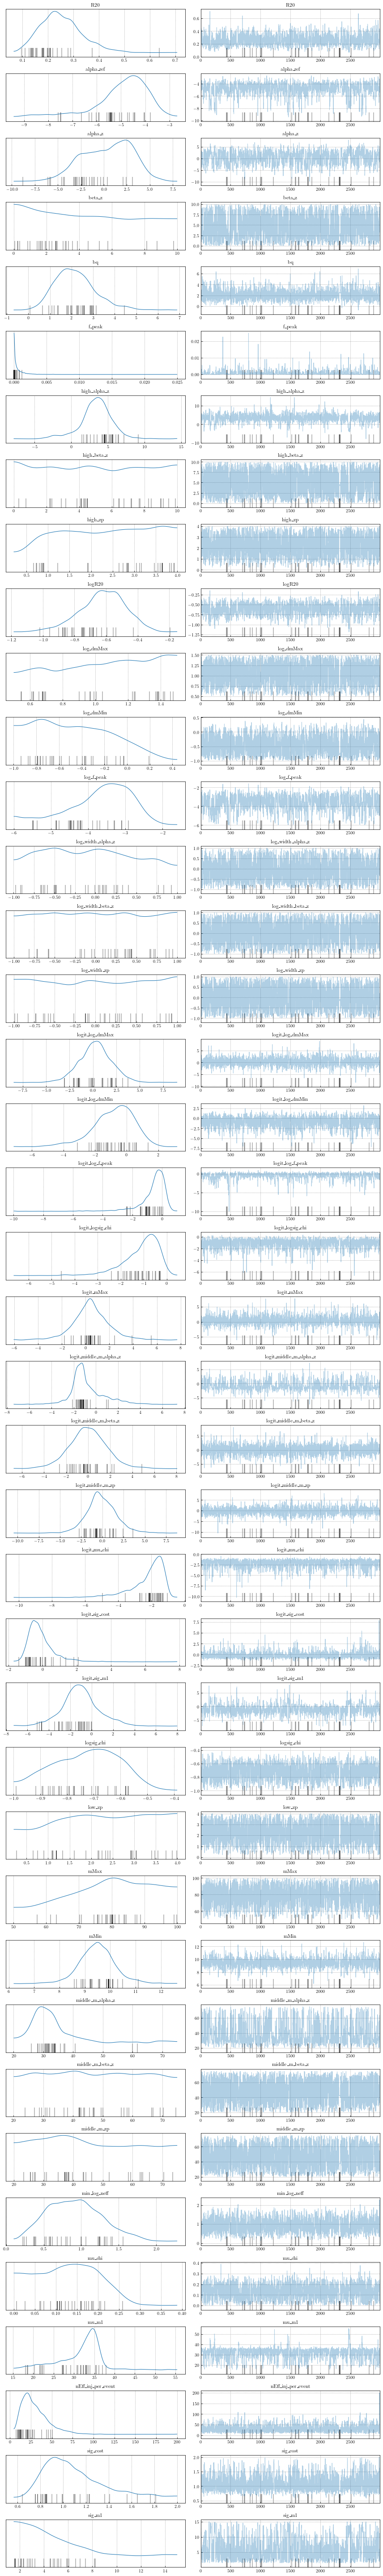

In [3]:
az.plot_trace(data)
plt.tight_layout()
plt.show()

In [3]:
def sigmoid_zp(low, high, width, middle, mass):
    return (high - low) / (1 + jnp.exp(-(1/width)*(mass - middle))) + low

def sigmoid_delta(low, delta, width, middle, mass):
    return (delta) / (1 + jnp.exp(-(1/width)*(mass - middle))) + low

def merger_rate_zp_sigmoid(alpha_z,high_alpha, width_alpha_z, middle_alpha_z,
                           beta_z, high_beta_z, width_beta_z, middle_beta_z,
                           low_zp, high_zp, width_m, m_middle, masses, z_s):
    alpha_z = sigmoid_zp(alpha_z, high_alpha, width_alpha_z, middle_alpha_z, masses)
    beta_z = sigmoid_zp(beta_z, high_beta_z, width_beta_z, middle_beta_z, masses)
    new_zp = sigmoid_zp(low_zp, high_zp, width_m, m_middle, masses)
    return (1+z_s)**alpha_z/(1+((1+z_s)/(1+new_zp))**(alpha_z+beta_z))

m_grid = np.linspace(2,120,500)

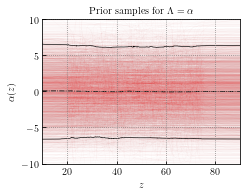

In [23]:
cm = 1/2.54
masses = np.linspace(0,90, 5000)
fig1, ax1 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax1.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_z.size)), len(masses)))

prior_alpha_z = rand.normal(0,4, samps.alpha_ref.size)
prior_high_alpha_z = rand.normal(0, 4, samps.alpha_ref.size)
prior_width_alpha_z = rand.uniform(-1,1, samps.alpha_ref.size)
prior_middle_alpha_z = rand.uniform(20, 75, samps.alpha_ref.size)

for i in range(samps.alpha_ref.size):
    alpha_r = sigmoid_zp(prior_alpha_z[i],
                               prior_high_alpha_z[i],
                               10.**prior_width_alpha_z[i],
                               prior_middle_alpha_z[i],
                               masses,
                              )
    ax1.plot(masses, alpha_r, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r

alpha_median = np.median(alpha_matrix, axis = 0)
plt.xlim(10, 90)
plt.ylim(-10, 10)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\alpha(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
only_prior_alpha_median = alpha_median
only_prior_alpha_quantile_5 = np.quantile(alpha_matrix,0.05,axis=0)
only_prior_alpha_quantile_95 = np.quantile(alpha_matrix,0.95,axis=0)
ax1.plot(masses, only_prior_alpha_median, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,only_prior_alpha_quantile_5, zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,only_prior_alpha_quantile_95, zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"Prior samples for $\Lambda = \alpha$", fontsize = 10)
plt.savefig("Prior_trace_alpha_z.pdf", dpi=400, bbox_inches='tight')
plt.show()

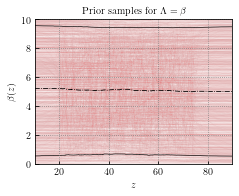

In [22]:
cm = 1/2.54
masses = np.linspace(0,90, 5000)
fig1, ax1 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax1.set_rasterization_zorder(2)
beta_matrix = np.zeros((len(range(samps.beta_z.size)), len(masses)))

prior_beta_z = rand.uniform(0,10, samps.beta_z.size)
prior_high_beta_z = rand.uniform(0, 10, samps.beta_z.size)
prior_width_beta_z = rand.uniform(-1,1, samps.beta_z.size)
prior_middle_beta_z = rand.uniform(20, 75, samps.beta_z.size)

for i in range(samps.beta_z.size):
    beta_r = sigmoid_zp(prior_beta_z[i],
                               prior_high_beta_z[i],
                               10.**prior_width_beta_z[i],
                               prior_middle_beta_z[i],
                               masses,
                              )
    ax1.plot(masses, beta_r, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    beta_matrix[i, :] = beta_r

beta_median = np.median(beta_matrix, axis = 0)
plt.xlim(10, 90)
plt.ylim(0, 10)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\beta(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
only_prior_beta_median = beta_median
only_prior_beta_quantile_5 = np.quantile(beta_matrix,0.05,axis=0)
only_prior_beta_quantile_95 = np.quantile(beta_matrix,0.95,axis=0)
ax1.plot(masses, only_prior_beta_median, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,only_prior_beta_quantile_5, zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,only_prior_beta_quantile_95, zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"Prior samples for $\Lambda = \beta$", fontsize = 10)
plt.savefig("Prior_trace_beta_z.pdf", dpi=400, bbox_inches='tight')
plt.show()

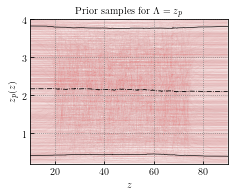

In [21]:
cm = 1/2.54
masses = np.linspace(0,90, 5000)
fig1, ax1 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax1.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_z.size)), len(masses)))

prior_zp_z = rand.uniform(0.2,4, samps.alpha_ref.size)
prior_high_zp_z = rand.uniform(0.2, 4, samps.alpha_ref.size)
prior_width_zp_z = rand.uniform(-1,1, samps.alpha_ref.size)
prior_middle_zp_z = rand.uniform(20, 75, samps.alpha_ref.size)

for i in range(samps.alpha_ref.size):
    zp_r = sigmoid_zp(prior_zp_z[i],
                               prior_high_zp_z[i],
                               10.**prior_width_zp_z[i],
                               prior_middle_zp_z[i],
                               masses,
                              )
    ax1.plot(masses, zp_r, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    zp_matrix[i, :] = zp_r

zp_median = np.median(zp_matrix, axis = 0)
plt.xlim(10, 90)
plt.ylim(0.2, 4)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$z_p(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
only_prior_zp_median = zp_median
only_prior_zp_quantile_5 = np.quantile(zp_matrix,0.05,axis=0)
only_prior_zp_quantile_95 = np.quantile(zp_matrix,0.95,axis=0)
ax1.plot(masses, only_prior_zp_median, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,only_prior_zp_quantile_5, zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,only_prior_zp_quantile_95, zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"Prior samples for $\Lambda = z_p$", fontsize = 10)
plt.savefig("Prior_trace_zp_z.pdf", dpi=400, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2204615/1411625071.py:18: RuntimeWarning: overflow encountered in exp
  intermediate_step = 1 + np.exp(samps.middle_m_alpha_z.values[i]/samps.width_alpha_z.values[i])


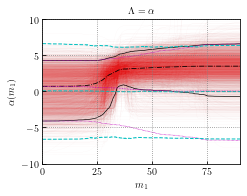

In [74]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.alpha_z.size):
    prior_alpha = rand.normal(0, 4)
    prior_high_alpha = rand.normal(0, 4)
    prior_width_alpha = rand.uniform(-1,1)
    prior_middle_alpha = rand.uniform(20, 75)
    posterior_value_z_0 = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_alpha_z.values[i]/samps.width_alpha_z.values[i])
    value_at_z_0 = samps.alpha_z.values[i] + (
        (samps.high_alpha_z.values[i] - samps.alpha_z.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
    low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
    low_value_z_matrix[i] = low_z_value_alpha
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    alpha_r_post = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               masses,
                              )
    plt.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
plt.xlim(0,90)
plt.ylim(-10, 10)
plt.xlabel(r"$m_1$", fontsize = 10)
plt.ylabel(r"$\alpha(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses, only_prior_alpha_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \alpha$", fontsize = 10)
plt.savefig("Prior_random_tuning_to_posterior_at_m_0_alpha_z.pdf", dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2204615/4249641565.py:22: RuntimeWarning: overflow encountered in exp
  intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
/tmp/ipykernel_2204615/4249641565.py:23: RuntimeWarning: invalid value encountered in double_scalars
  low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
/tmp/ipykernel_2204615/4249641565.py:18: RuntimeWarning: overflow encountered in exp
  intermediate_step = 1 + np.exp(samps.middle_m_beta_z.values[i]/samps.width_beta_z.values[i])


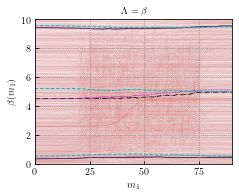

In [75]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.beta_z.size):
    prior_alpha = rand.uniform(0, 10)
    prior_high_alpha = rand.uniform(0, 10)
    prior_width_alpha = rand.uniform(-1,1)
    prior_middle_alpha = rand.uniform(20, 75)
    posterior_value_z_0 = sigmoid_zp(samps.beta_z.values[i],
                               samps.high_beta_z.values[i],
                               10.**samps.log_width_beta_z.values[i],
                               samps.middle_m_beta_z.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_beta_z.values[i]/samps.width_beta_z.values[i])
    value_at_z_0 = samps.beta_z.values[i] + (
        (samps.high_beta_z.values[i] - samps.beta_z.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
    low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_alpha
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    
    alpha_r_post = sigmoid_zp(samps.beta_z.values[i],
                               samps.high_beta_z.values[i],
                               10.**samps.log_width_beta_z.values[i],
                               samps.middle_m_beta_z.values[i],
                               masses,
                              )
    plt.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
plt.xlim(0,90)
plt.ylim(0, 10)
plt.xlabel(r"$m_1$", fontsize = 10)
plt.ylabel(r"$\beta(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses, only_prior_beta_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_beta_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_beta_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \beta$", fontsize = 10)
plt.savefig("Prior_random_tuning_to_posterior_at_m_0_beta_z.pdf", dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2204615/3803724664.py:22: RuntimeWarning: overflow encountered in exp
  intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
/tmp/ipykernel_2204615/3803724664.py:23: RuntimeWarning: invalid value encountered in double_scalars
  low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
/tmp/ipykernel_2204615/3803724664.py:18: RuntimeWarning: overflow encountered in exp
  intermediate_step = 1 + np.exp(samps.middle_m_zp.values[i]/samps.width_zp.values[i])


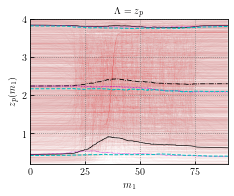

In [76]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.low_zp.size):
    prior_alpha = rand.uniform(0.2, 4)
    prior_high_alpha = rand.uniform(0.2, 4)
    prior_width_alpha = rand.uniform(-1,1)
    prior_middle_alpha = rand.uniform(20, 75)
    posterior_value_z_0 = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_zp.values[i]/samps.width_zp.values[i])
    value_at_z_0 = samps.low_zp.values[i] + (
        (samps.high_zp.values[i] - samps.low_zp.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
    low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_alpha
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    
    alpha_r_post = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               masses,
                              )
    plt.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
plt.xlim(0,90)
plt.ylim(0.2, 4)
plt.xlabel(r"$m_1$", fontsize = 10)
plt.ylabel(r"$z_p(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses,np.nanquantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
plt.plot(masses, only_prior_zp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_zp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(masses, only_prior_zp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = z_p$", fontsize = 10)
plt.savefig("Prior_random_tuning_to_posterior_at_m_0_zp.pdf", dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2204615/1080591830.py:19: RuntimeWarning: overflow encountered in exp
  intermediate_step = 1 + np.exp(samps.middle_m_alpha_z.values[i]/samps.width_alpha_z.values[i])
/tmp/ipykernel_2204615/1080591830.py:76: RuntimeWarning: overflow encountered in exp
  intermediate_step = 1 + np.exp(samps.middle_m_zp.values[i]/samps.width_zp.values[i])


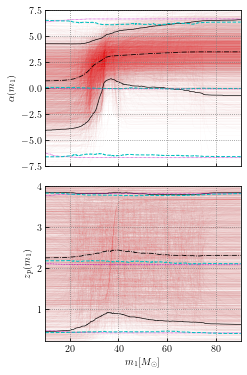

In [77]:
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9*cm, 2*6.75*cm))

ax1.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.alpha_z.size):
    prior_alpha = rand.normal(0, 4)
    prior_high_alpha = rand.normal(0, 4)
    prior_width_alpha = rand.uniform(-1,1)
    prior_middle_alpha = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_alpha_z.values[i]/samps.width_alpha_z.values[i])
    value_at_z_0 = samps.alpha_z.values[i] + (
        (samps.high_alpha_z.values[i] - samps.alpha_z.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
    low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_alpha
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    
    alpha_r_post = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               masses,
                              )
    ax1.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
ax1.set_ylim(-7.5, 7.5)
ax1.set_ylabel(r"$\alpha(m_1)$", fontsize = 10)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax1.plot(masses,np.nanquantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax1.plot(masses,np.nanquantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax1.plot(masses, only_prior_alpha_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


ax2.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
zp_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.low_zp.size):
    prior_zp = rand.uniform(0.2, 4)
    prior_high_zp = rand.uniform(0.2, 4)
    prior_width_zp = rand.uniform(-1,1)
    prior_middle_zp = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_zp.values[i]/samps.width_zp.values[i])
    value_at_z_0 = samps.low_zp.values[i] + (
        (samps.high_zp.values[i] - samps.low_zp.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_zp/(10**(prior_width_zp)))
    low_z_value_zp = (prior_high_zp - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_zp
    zp_r = sigmoid_zp(low_z_value_zp,
                               prior_high_zp,
                               10.**prior_width_zp,
                               prior_middle_zp,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', zp = 0.2, zorder = 1)
    zp_matrix[i, :] = zp_r
    
    zp_r_post = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               masses,
                              )
    plt.plot(masses, zp_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    zp_matrix_post[i, :] = zp_r_post

median_zp = np.nanmedian(zp_matrix, axis = 0)
median_zp_post = np.median(zp_matrix_post, axis = 0)
ax2.set_xlim(10,90)
ax2.set_ylim(0.2, 4)
ax2.set_xlabel(r"$m_1 [M_\odot]$", fontsize = 10)
ax2.set_ylabel(r"$z_p(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax2.plot(masses, median_zp_post, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(masses,np.quantile(zp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses,np.quantile(zp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses, median_zp, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax2.plot(masses,np.nanquantile(zp_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax2.plot(masses,np.nanquantile(zp_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax2.plot(masses, only_prior_zp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

plt.setp(ax1.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("Reverse_conditional_plot.pdf", dpi=500, bbox_inches="tight")
plt.show()

In [ ]:
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9*cm, 2*6.75*cm))

ax1.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.alpha_z.size):
    prior_alpha = rand.normal(0, 4)
    prior_high_alpha = rand.normal(0, 4)
    prior_width_alpha = rand.uniform(-1,1)
    prior_middle_alpha = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               10,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_alpha_z.values[i]/samps.width_alpha_z.values[i])
    value_at_z_0 = samps.alpha_z.values[i] + (
        (samps.high_alpha_z.values[i] - samps.alpha_z.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_alpha/(10**(prior_width_alpha)))
    low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_alpha
    alpha_r = sigmoid_zp(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    
    alpha_r_post = sigmoid_zp(samps.alpha_z.values[i],
                               samps.high_alpha_z.values[i],
                               10.**samps.log_width_alpha_z.values[i],
                               samps.middle_m_alpha_z.values[i],
                               masses,
                              )
    ax1.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.median(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
ax1.set_ylim(-7.5, 7.5)
ax1.set_ylabel(r"$\alpha(m_1)$", fontsize = 10)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax1.plot(masses,np.quantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax1.plot(masses,np.quantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax1.plot(masses, only_prior_alpha_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


ax2.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
zp_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(masses)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.low_zp.size):
    prior_zp = rand.uniform(0.2, 4)
    prior_high_zp = rand.uniform(0.2, 4)
    prior_width_zp = rand.uniform(-1,1)
    prior_middle_zp = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               0,
                              )
    intermediate_step = 1 + np.exp(samps.middle_m_zp.values[i]/samps.width_zp.values[i])
    value_at_z_0 = samps.low_zp.values[i] + (
        (samps.high_zp.values[i] - samps.low_zp.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_zp/(10**(prior_width_zp)))
    low_z_value_zp = (prior_high_zp - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_zp
    zp_r = sigmoid_zp(low_z_value_zp,
                               prior_high_zp,
                               10.**prior_width_zp,
                               prior_middle_zp,
                               masses,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', zp = 0.2, zorder = 1)
    zp_matrix[i, :] = zp_r
    
    zp_r_post = sigmoid_zp(samps.low_zp.values[i],
                               samps.high_zp.values[i],
                               10.**samps.log_width_zp.values[i],
                               samps.middle_m_zp.values[i],
                               masses,
                              )
    plt.plot(masses, zp_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    zp_matrix_post[i, :] = zp_r_post

median_zp = np.median(zp_matrix, axis = 0)
median_zp_post = np.median(zp_matrix_post, axis = 0)
ax2.set_xlim(10,90)
ax2.set_ylim(0.2, 4)
ax2.set_xlabel(r"$m_1 [M_\odot]$", fontsize = 10)
ax2.set_ylabel(r"$z_p(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax2.plot(masses, median_zp_post, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(masses,np.quantile(zp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses,np.quantile(zp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses, median_zp, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax2.plot(masses,np.quantile(zp_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax2.plot(masses,np.quantile(zp_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax2.plot(masses, only_prior_zp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

plt.setp(ax1.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("Reverse_conditional_plot_gauged_at_m_10.pdf", dpi=500, bbox_inches="tight")
plt.show()

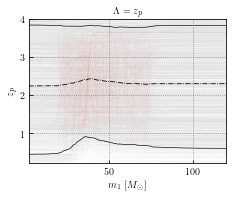

In [6]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
zp_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))
for i in range(samps.alpha_ref.size):
    zp = sigmoid_zp(samps.low_zp.values[i], samps.high_zp.values[i], 10.**samps.log_width_zp.values[i], samps.middle_m_zp.values[i], m_grid)
    ax.plot(m_grid, zp, color='#e31a1c', lw=0.05, alpha = 0.1, zorder = 1)
    zp_matrix[i, :] = zp
    
median_zp = np.median(zp_matrix, axis = 0)
    
ax.set_xlim(2,120)
ax.set_ylim(0.2,4)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax.set_ylabel(r"$z_p$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.plot(m_grid, median_zp, "-.", c="k", zorder = 1, lw = 0.8)
ax.plot(m_grid,np.quantile(zp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax.plot(m_grid,np.quantile(zp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = z_p$", fontsize = 10)
plt.savefig("Trace_zp_reverse.pdf", dpi = 400, bbox_inches = "tight")
plt.show()

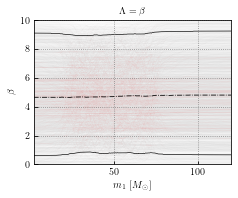

In [7]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
beta_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))
for i in range(samps.alpha_ref.size):
    zp = sigmoid_zp(samps.beta_z.values[i], samps.high_beta_z.values[i], 10.**samps.width_beta_z.values[i], samps.middle_m_beta_z.values[i], m_grid)
    ax.plot(m_grid, zp, color='#e31a1c', lw=0.05, alpha = 0.1, zorder = 1)
    beta_matrix[i, :] = zp
    
median_beta = np.median(beta_matrix, axis = 0)

ax.set_xlim(2,120)
ax.set_ylim(0,10)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax.set_ylabel(r"$\beta$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.plot(m_grid, median_beta, "-.", c="k", zorder = 1, lw = 0.8)
ax.plot(m_grid,np.quantile(beta_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax.plot(m_grid,np.quantile(beta_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = \beta$", fontsize = 10)
plt.savefig("Trace_beta_reverse.pdf", dpi = 400, bbox_inches = "tight")
plt.show()

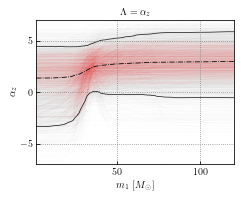

In [10]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))
for i in range(samps.alpha_ref.size):
    zp = sigmoid_zp(samps.alpha_z.values[i], samps.high_alpha_z.values[i], 10.**samps.width_alpha_z.values[i], samps.middle_m_alpha_z.values[i], m_grid)
    ax.plot(m_grid, zp, color='#e31a1c', lw=0.05, alpha = 0.1, zorder = 1)
    alpha_matrix[i, :] = zp
    
median_alpha = np.median(alpha_matrix, axis = 0)
ax.set_xlim(2,120)
ax.set_ylim(-7,7)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax.set_ylabel(r"$\alpha_z$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.plot(m_grid, median_alpha, "-.", c="k", zorder = 1, lw = 0.8)
ax.plot(m_grid,np.quantile(alpha_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax.plot(m_grid,np.quantile(alpha_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = \alpha_z$", fontsize = 10)
plt.savefig("Trace_alpha_reverse.pdf", dpi = 400, bbox_inches = "tight")
plt.show()